In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
from scipy.signal import find_peaks_cwt as peakFinder
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [2]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    return classData, coilData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

classData, coilData = importPickle("./inData/6060DataFrame.pkl")
illData, healthData = splitData(coilData, classData)

# Flatten arrays...
for i in np.arange(0,len(illData),1):
    illData[i] = np.hstack(illData[i])
illData = np.abs(np.hstack(illData))
for i in np.arange(0,len(healthData),1):
    healthData[i] = np.hstack(healthData[i])
healthData = np.abs(np.hstack(healthData))

270


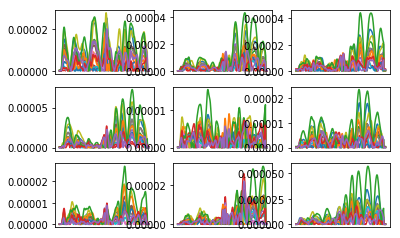

In [3]:
# Various plots...
r = randint(0,390)
print(r)
fig, ax = plt.subplots(3,3)
for i in np.arange(0,ax.shape[0],1):
    for j in np.arange(0,ax.shape[1],1):
        r = r+1
        for k in np.arange(0,15):
            ax[i,j].plot(np.abs(coilData[r][k, 0:2000]))
            ax[i,j].set_xticks([])

In [6]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Skip 'skip' number of items to reduce feeding in the
    same values.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def getSamples(arr, peakArr, buffer):
    """
    Get samples for array arr with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2: # Check that all samples are same size
            sampledData.append(arr[i-buffer: i+buffer])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in a similar way.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def functionTown(illArr, healthArr, illThreshold, healthThreshold, skip, buffer, shuf):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuf is true, shuffle data.
    """
    illPeakArr = findAbove(illArr, illThreshold, skip)
    illSampled = getSamples(illArr, illPeakArr, buffer)
    healthPeakArr = findAbove(healthArr, healthThreshold, skip)
    healthSampled = getSamples(healthArr, healthPeakArr, buffer)
    
    print("ill samples", len(illSampled))
    print("healthy samples", len(healthSampled))
    
    classData = []
    for i in np.arange(0, len(illSampled), 1):
        classData.append(1)
    for i in np.arange(0, len(healthSampled), 1):
        classData.append(0)
    ecgData = illSampled + healthSampled
    
    if shuf == True:
        classData, ecgData = shuffle2Lst(classData, ecgData)
        
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(np.concatenate(ecgData, axis=0), [len(ecgData), buffer*2, 1])
    
    return ecgData, classDataOH, classData
    
buffer = 500
healthThreshold = 0.00005
illThreshold = 0.00006
skip = 20
shuf = True

ecgData, classDataOH, classData = functionTown(illData, healthData, illThreshold, healthThreshold, skip, buffer, shuf)

ill samples 1343
healthy samples 1258


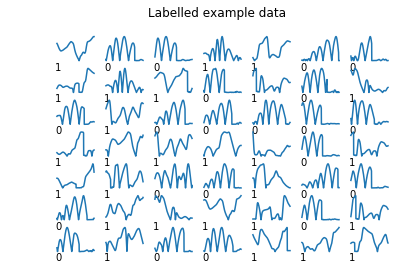

In [5]:
visualiseData(ecgData, classData, 7)
#plt.savefig("./outData/figures/messy_mcg_example.pdf")

# Neural Network

In [270]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, buffer*2, 1])
    
# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 10, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.001)

In [271]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(ecgData, classDataOH, n_epoch=20, validation_set=0.2, show_metric=True)

Training Step: 660  | total loss: 0.26377
| Adam | epoch: 020 | loss: 0.26377 - acc: 0.9194 | val_loss: 0.07651 - val_acc: 0.9846 -- iter: 2080/2080
Training Step: 660  | total loss: 0.26377
| Adam | epoch: 020 | loss: 0.26377 - acc: 0.9194 | val_loss: 0.07651 - val_acc: 0.9846 -- iter: 2080/2080
--


In [241]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/0-88-messyMCG_"+now.isoformat()+"_.tflearn")

INFO:tensorflow:././outData/models/0-88-messyMCG_2017-02-17T11:04:42.891681_.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [273]:
tbuffer = 500
thealthThreshold = 0.00005
tillThreshold = 0.00006
tskip = 20

tecgData, tclassDataOH, tclassData = functionTown(illData, healthData, tillThreshold, thealthThreshold, tskip, tbuffer, False)

ill samples 1343
healthy samples 1258


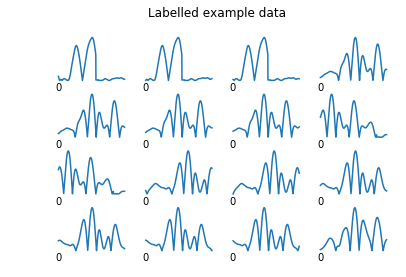

In [276]:
visualiseData(tecgData, tclassData, 4)

In [232]:
#model.load("./outData/models/cleanECG_2017-02-14T23:10:17.479693_.tflearn")
tecgData = np.reshape(np.concatenate(tecgData, axis=0), [len(tecgData), tbuffer*2, 1])
print("Sensitivity:", model.evaluate(tecgData[644:], tclassDataOH[644:]), "Specifity:",\
    model.evaluate(tecgData[:644], tclassDataOH[:644]),\
    "Accuracy:", model.evaluate(tecgData, tclassDataOH))

Sensitivity: [1.0] Specifity: [0.04503105590062112] Accuracy: [0.63844797178130508]
